# Creating dataset from video

Load tracking data

In [153]:
import pandas as pd
import matplotlib.pyplot as plt

In [154]:
source_csv_file = 'data/tracking_data.csv'
destination_csv_file = 'data/classification_dataset.csv'

In [155]:
source_csv_file = 'data/tracking_data.csv'
df = pd.read_csv(source_csv_file)
df.head()

,frame,id,x1,y1,x2,y2,xc,yc,class,wave,video
0,12,0,-5,336,396,785,195,560,palm,1,video1.mp4
1,12,1,1297,389,1554,751,1425,570,palm,1,video1.mp4
2,13,0,-5,291,391,740,193,515,palm,1,video1.mp4
3,13,1,1299,356,1556,720,1427,538,palm,1,video1.mp4
4,14,0,-5,252,385,703,190,477,palm,1,video1.mp4


`window_function` is a function that returns labeled windows for given `id` and `video` and `starting_window`. Windows is number of frames for which signal is considered. In our case we want to detect hand wave, so we will use `window_size` = 30, as our camera captures 30 frames per second. 

In [156]:
def window_function(df, id, video, starting_window, window_size=30, skip=2):
    labeled_windows = []  # List to store labeled windows
    
    # Filter DataFrame rows for the given ID and video
    id_video_df = df[(df['id'] == id) & (df['video'] == video)]

    # Iterate over the DataFrame rows with specified skip
    for start_idx in range(0, len(id_video_df) - window_size + 1, skip):
        # Extract frames for the current window
        window_frames = id_video_df.iloc[start_idx:start_idx+window_size]
        
        # Append the window and its label to the list
        labeled_windows.append((window_frames, starting_window))
        starting_window += 1  # Increment the window number
    
    return labeled_windows

Create new dataset with `window` label, so that we have signals of the same length.

In [157]:
starting_window = 0 # will be unique accross all videos

new_df = df.copy()

# Iterate over each unique combination of ID and video name in the DataFrame
for (id, video) in df[['id', 'video']].drop_duplicates().itertuples(index=False):
    # Get labeled windows for the current ID and video name
    id_video_windows = window_function(df, id=id, video=video, skip=10, window_size=30, starting_window=starting_window)
    starting_window += len(id_video_windows)  # Update starting window for the next video

    for window, window_number in id_video_windows:
        new_df = pd.concat([new_df, window.assign(window=window_number)])


# remove rows with NaN values which were noise
new_df.dropna(inplace=True)
new_df.reset_index(drop=True, inplace=True)

# Convert 'window_num' column to integer type
new_df['window'] = new_df['window'].astype(int)
for i in range(0, 19):
    print(f'Window size: {new_df[new_df.window == i].shape[0]} for window {i} video: {new_df.video[new_df.window == i].iloc[0]}, id: {new_df.id[new_df.window == i].iloc[0]}')

Window size: 30 for window 0 video: video1.mp4, id: 1
Window size: 30 for window 1 video: video1.mp4, id: 1
Window size: 30 for window 2 video: video1.mp4, id: 1
Window size: 30 for window 3 video: video1.mp4, id: 1
Window size: 30 for window 4 video: video1.mp4, id: 1
Window size: 30 for window 5 video: video1.mp4, id: 1
Window size: 30 for window 6 video: video1.mp4, id: 1
Window size: 30 for window 7 video: video1.mp4, id: 1
Window size: 30 for window 8 video: video1.mp4, id: 1
Window size: 30 for window 9 video: video1.mp4, id: 1
Window size: 30 for window 10 video: video1.mp4, id: 1
Window size: 30 for window 11 video: video1.mp4, id: 1
Window size: 30 for window 12 video: video1.mp4, id: 1
Window size: 30 for window 13 video: video1.mp4, id: 3
Window size: 30 for window 14 video: video1.mp4, id: 3
Window size: 30 for window 15 video: video1.mp4, id: 3
Window size: 30 for window 16 video: video1.mp4, id: 3
Window size: 30 for window 17 video: video1.mp4, id: 3
Window size: 30 for 

Save dataset to `data` folder.

In [158]:
# Save the new DataFrame to a CSV file
new_df.to_csv(destination_csv_file, index=False)

# Preprocessing data

loading dataset

In [159]:
dataset = pd.read_csv(destination_csv_file)
dataset.head()

,frame,id,x1,y1,x2,y2,xc,yc,class,wave,video,window
0,12,1,1297,389,1554,751,1425,570,palm,1,video1.mp4,0
1,13,1,1299,356,1556,720,1427,538,palm,1,video1.mp4,0
2,14,1,1298,327,1553,692,1425,509,palm,1,video1.mp4,0
3,15,1,1295,305,1550,673,1422,489,palm,1,video1.mp4,0
4,16,1,1293,290,1546,663,1419,476,palm,1,video1.mp4,0


In [160]:
def plot_wave(xc, yc, title):
    fig, axs = plt.subplots(3, 1, figsize=(8, 10))
    
    # Plot xc
    axs[0].plot(range(len(xc)), xc, label='X center', color='purple')
    axs[0].set_title(title)
    axs[0].set_xlabel('Frame')
    axs[0].set_ylabel('Amplitude')
    axs[0].legend(loc='upper right')
    
    # Plot yc
    axs[1].plot(range(len(yc)), yc, label='Y center', color='green')
    axs[1].set_xlabel('Frame')
    axs[1].set_ylabel('Amplitude')
    axs[1].legend(loc='upper right')

    # Plot xc and yc
    axs[2].plot(xc, yc, label='Movement', color='red')
    axs[2].set_xlabel('X center')
    axs[2].set_ylabel('Y center')
    axs[2].legend(loc='upper right')
    axs[2].set_aspect('equal', adjustable='box')  # Set square shape
    
    plt.tight_layout()
    plt.show()

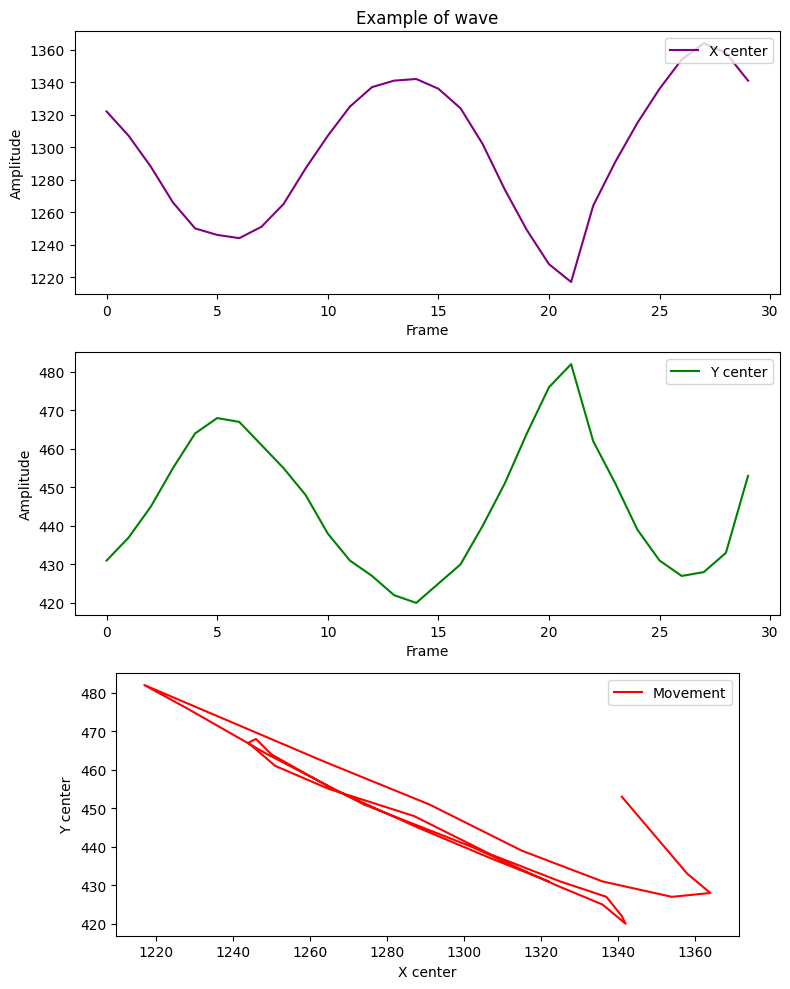

30 30


In [173]:
window = 12
xc = dataset.xc[(dataset.window == window) & (dataset.wave == 1)]
yc = dataset.yc[(dataset.window == window) & (dataset.wave == 1)]
plot_wave(xc, yc, "Example of wave")
print(len(xc), len(yc))